In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Load dataset


In [ ]:
df = pd.read_csv("../Data/Source_dataset/news.csv")
df.head()

,date,news,neg,neu,pos,compound,sentiment
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE


# Analyse the data

Visualize the distribution of the data

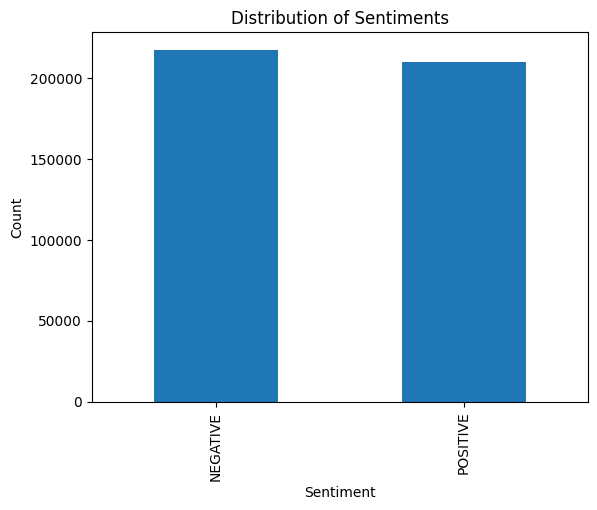

In [5]:
df['sentiment'].value_counts().plot(kind='bar')

plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

**Note:** We can see that the data is balanced

In [6]:
df.describe()

,neg,neu,pos,compound
count,427482.000000,427482.000000,427482.000000,427482.000000
mean,0.140294,0.742719,0.116985,0.243870
std,0.166470,0.162196,0.135587,0.623274
min,0.000000,0.000000,0.000000,-0.990800
25%,0.000000,0.672000,0.004264,-0.340000
50%,0.095000,0.782000,0.087000,0.361200
75%,0.207872,0.861000,0.167336,0.877805
max,1.000000,0.980000,1.000000,0.999887


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427482 entries, 0 to 427481
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       427482 non-null  object 
 1   news       427482 non-null  object 
 2   neg        427482 non-null  float64
 3   neu        427482 non-null  float64
 4   pos        427482 non-null  float64
 5   compound   427482 non-null  float64
 6   sentiment  427482 non-null  object 
dtypes: float64(4), object(3)
memory usage: 22.8+ MB


**Note:** we can see that there is no null values in the data

In [8]:
num_duplicates = df.duplicated().sum()
num_duplicates

0

Let's explore the length of news

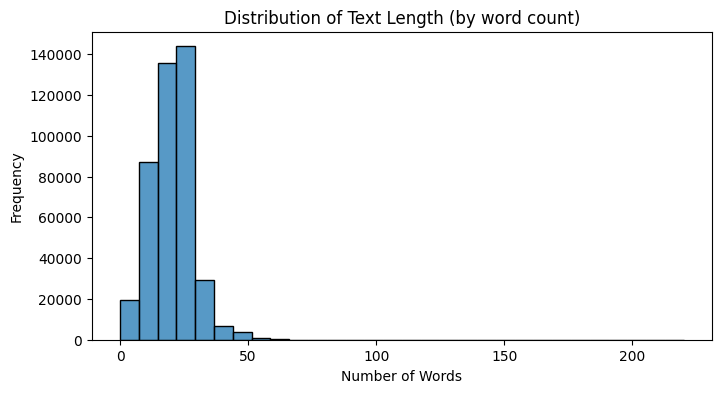

In [9]:
df['text_length'] = df['news'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=30, kde=False)
plt.title('Distribution of Text Length (by word count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

Top words Frequeincies

In [10]:
import re
import nltk
nltk.download('punkt_tab')  # Make sure to download 'punkt' for word_tokenize
from nltk.tokenize import word_tokenize
from collections import Counter
def simple_tokenize(text):
    """
    A simple tokenizer using NLTK word_tokenize.
    You could replace this with a more sophisticated approach
    (e.g., spaCy) if desired.
    """
    # Lowercase
    text = text.lower()
    # Remove extra characters (optional)
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    # Tokenize
    tokens = word_tokenize(text)
    return tokens

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [11]:
# Apply to entire DataFrame (you can store tokens in a new column if desired)
df['tokens'] = df['news'].apply(simple_tokenize)

# Separate out positive and negative texts for comparison
positive_texts = df[df['sentiment'] == 'POSITIVE']['tokens']
negative_texts = df[df['sentiment'] == 'NEGATIVE']['tokens']

# Flatten lists of tokens
pos_tokens_flat = [token for tokens in positive_texts for token in tokens]
neg_tokens_flat = [token for tokens in negative_texts for token in tokens]

pos_freq = Counter(pos_tokens_flat).most_common(10)
neg_freq = Counter(neg_tokens_flat).most_common(10)

print("\nTop 10 tokens in POSITIVE texts:")
for token, freq in pos_freq:
    print(f"{token}: {freq}")

print("\nTop 10 tokens in NEGATIVE texts:")
for token, freq in neg_freq:
    print(f"{token}: {freq}")


Top 10 tokens in POSITIVE texts:
the: 258245
a: 131220
to: 113047
of: 109812
and: 107395
in: 96406
for: 45696
on: 37930
is: 35349
with: 29360

Top 10 tokens in NEGATIVE texts:
the: 245402
a: 123574
of: 118805
to: 112295
in: 103918
and: 89328
for: 44211
on: 42139
is: 33232
that: 32516


**Note**: we can see that the words that are the most frequent words have no effects on the sentiment and they are stop words so we need to remove them in next step


Generating Word Clouds...


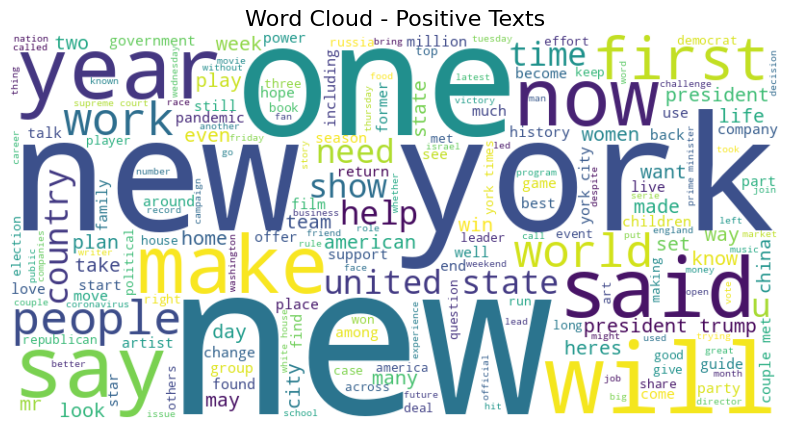

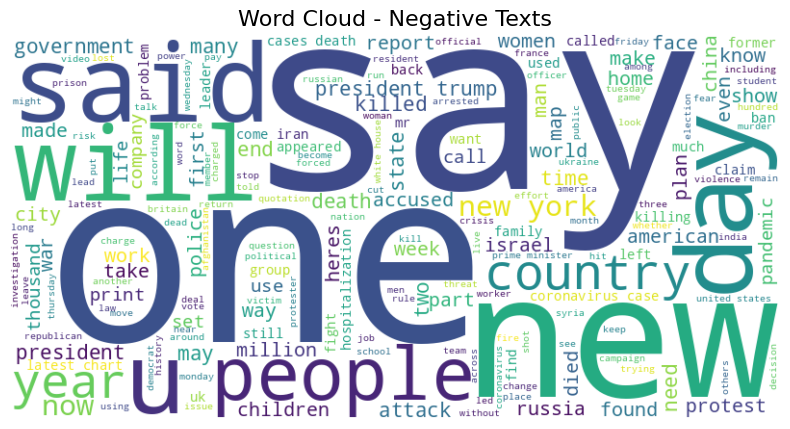

In [12]:
from wordcloud import WordCloud
def plot_wordcloud(token_list, title):
    """
    Given a list of tokens, generate and display a word cloud.
    """
    # Convert tokens to a single string
    text_string = " ".join(token_list)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

print("\nGenerating Word Clouds...")
plot_wordcloud(pos_tokens_flat, "Word Cloud - Positive Texts")
plot_wordcloud(neg_tokens_flat, "Word Cloud - Negative Texts")

In [13]:
from nltk.util import ngrams

def get_top_ngrams(token_list, n=2, top_k=10):
    """
    Compute top-k most common n-grams (for n=2 bigrams, n=3 trigrams, etc.).
    token_list should be a list of tokens (already cleaned).
    """
    # Generate n-grams
    n_grams = ngrams(token_list, n)
    freq_dist = Counter(n_grams)
    return freq_dist.most_common(top_k)

# Example: Top 10 bigrams in positive texts
pos_bigrams = get_top_ngrams(pos_tokens_flat, n=2, top_k=10)
print("\nTop 10 BIGRAMS in POSITIVE texts:")
for bigram, freq in pos_bigrams:
    print(f"{bigram}: {freq}")

# Example: Top 10 trigrams in negative texts
neg_trigrams = get_top_ngrams(neg_tokens_flat, n=3, top_k=10)
print("\nTop 10 TRIGRAMS in NEGATIVE texts:")
for trigram, freq in neg_trigrams:
    print(f"{trigram}: {freq}")



Top 10 BIGRAMS in POSITIVE texts:
('of', 'the'): 25364
('in', 'the'): 21140
('to', 'the'): 9252
('for', 'the'): 8728
('on', 'the'): 8457
('at', 'the'): 7896
('in', 'a'): 7776
('and', 'the'): 7673
('new', 'york'): 7521
('of', 'a'): 5810

Top 10 TRIGRAMS in NEGATIVE texts:
('of', 'the', 'day'): 3548
('the', 'day', 'for'): 2061
('quotation', 'of', 'the'): 2055
('in', 'print', 'on'): 2050
('the', 'end', 'of'): 2011
('of', 'coronavirus', 'cases'): 1906
('see', 'the', 'latest'): 1869
('the', 'latest', 'charts'): 1869
('coronavirus', 'cases', 'deaths'): 1868
('latest', 'charts', 'and'): 1867


# Data Cleaning

## Lower case the text

In [14]:
def lowecasing(text):
    return text.lower()
df['cleaned_text'] = df['news'].apply(lowecasing)
df.head()

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE,37,"[it, was, a, long, antipodean, night, while, t...",it was a long antipodean night. while there’s ...
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE,49,"[in, mexico, there, are, no, licensing, or, re...",in mexico there are no licensing or registrati...
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE,24,"[the, government, has, until, monday, to, prot...",the government has until monday to protect the...
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE,10,"[a, recordbreaking, heat, wave, in, the, south...",a record-breaking heat wave in the southwest i...
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE,65,"[england, started, its, live, earth, concert, ...",england started its live earth concert at wemb...


## Remove URLs, Hashtags,Imogies and Mentions

Let's check for mentions


In [15]:
def check_mentions(text):
    mentions = re.findall(r'@\w+', text)
    return mentions
df['mentions'] = df['cleaned_text'].apply(check_mentions)



In [16]:
df[df['mentions'].apply(len)>0]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions
9366,2009-06-17,"b""Attention Iranian Redditors! Help the Irania...",0.037000,0.858000,0.105000,0.574700,POSITIVE,50,"[battention, iranian, redditors, help, the, ir...","b""attention iranian redditors! help the irania...",[@x0rz]
23606,2011-01-09,"WARNING: all 637,000 @wikileaks followers are ...",0.173000,0.827000,0.000000,-0.482400,NEGATIVE,18,"[warning, all, 637000, wikileaks, followers, a...","warning: all 637,000 @wikileaks followers are ...",[@wikileaks]
24669,2011-02-20,"Protests now reach China, 13 cities joined the...",0.073000,0.885000,0.042000,-0.202300,NEGATIVE,26,"[protests, now, reach, china, 13, cities, join...","protests now reach china, 13 cities joined the...",[@junlinghu]
32420,2011-12-27,If you could tweet on behalf of your country -...,0.000000,0.941000,0.059000,0.250000,POSITIVE,33,"[if, you, could, tweet, on, behalf, of, your, ...",if you could tweet on behalf of your country -...,[@sweden]
36641,2012-06-13,Colbert asks for @sweden Twitter control. Swed...,0.185664,0.761395,0.052941,0.990141,NEGATIVE,10,"[colbert, asks, for, sweden, twitter, control,...",colbert asks for @sweden twitter control. swed...,[@sweden]
...,...,...,...,...,...,...,...,...,...,...,...
353720,2021-06-02,The TikTok creator known as @itsmetinx has gai...,0.000000,0.833000,0.167000,0.612400,POSITIVE,27,"[the, tiktok, creator, known, as, itsmetinx, h...",the tiktok creator known as @itsmetinx has gai...,[@itsmetinx]
366711,2021-09-03,The 18-year-old behind the viral Twitter accou...,0.054738,0.697639,0.247623,0.994491,NEGATIVE,19,"[the, 18yearold, behind, the, viral, twitter, ...",the 18-year-old behind the viral twitter accou...,[@craigweekend]
370888,2021-10-01,"With a deft plan, @BritneyLawArmy kept everyon...",0.011782,0.634827,0.353391,0.999327,POSITIVE,21,"[with, a, deft, plan, britneylawarmy, kept, ev...","with a deft plan, @britneylawarmy kept everyon...",[@britneylawarmy]
385780,2022-01-25,"In this lesson, students will consider what th...",0.022982,0.891179,0.085839,0.986479,POSITIVE,18,"[in, this, lesson, students, will, consider, w...","in this lesson, students will consider what th...",[@nyt_first_said]


**Note:** We can see that 67 samples cony=tain mentions so let's remove them

In [17]:
def remove_mentions(text):
    return re.sub(r'@\w+', '', text)
df.loc[df['mentions'].apply(len) > 0, 'cleaned_text'] = df.loc[df['mentions'].apply(len) > 0, 'cleaned_text'].apply(remove_mentions)

In [18]:
df['mentions'] = df['cleaned_text'].apply(check_mentions)
df[df['mentions'].apply(len)>0]


,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions


Let's check for urls

In [19]:
def check_urls(text):
    urls = re.findall(r'http\S+|www.\S+', text)
    return urls
df['urls'] = df['cleaned_text'].apply(check_urls)
df[df['urls'].apply(len)>0]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls
1449,2008-08-04,b'US$ 50 mil scam: www.beijing-tickets2008.com...,0.429000,0.571000,0.000000,-0.817600,NEGATIVE,13,"[bus, 50, mil, scam, wwwbeijingtickets2008com,...",b'us$ 50 mil scam: www.beijing-tickets2008.com...,[],"[www.beijing-tickets2008.com, www .beijingtick..."
6208,2009-02-10,b'Pedophile upset that victim\'s family would ...,0.277000,0.723000,0.000000,-0.657100,NEGATIVE,16,"[bpedophile, upset, that, victims, family, wou...",b'pedophile upset that victim\'s family would ...,[],"[wwww,]"
6786,2009-03-05,"b'This what I get when I go to YouTube: ""Dear ...",0.105000,0.753000,0.142000,0.202300,POSITIVE,43,"[bthis, what, i, get, when, i, go, to, youtube...","b'this what i get when i go to youtube: ""dear ...",[],[www.pta.gov.pk)]
8528,2009-05-15,b'Piratebay DDo$ attack site (http://interneta...,0.237000,0.763000,0.000000,-0.476700,NEGATIVE,11,"[bpiratebay, ddo, attack, site, httpinternetav...",b'piratebay ddo$ attack site (http://interneta...,[],[http://internetavgift.se/)]
14629,2010-01-13,b'Please go to www.redcross.org and donate at ...,0.000000,0.880000,0.120000,0.457400,POSITIVE,25,"[bplease, go, to, wwwredcrossorg, and, donate,...",b'please go to www.redcross.org and donate at ...,[],[www.redcross.org]
22707,2010-12-04,"Wikileaks is not dead, only the url. you can ...",0.000000,0.823000,0.177000,0.533400,POSITIVE,17,"[wikileaks, is, not, dead, only, the, url, you...","wikileaks is not dead, only the url. you can ...",[],[www.wikileaks.ch]
25523,2011-03-26,Microsoft Compromises Users Privacy: No HTTPS ...,0.196000,0.804000,0.000000,-0.296000,NEGATIVE,10,"[microsoft, compromises, users, privacy, no, h...",microsoft compromises users privacy: no https ...,[],[https]
33538,2012-02-10,Iran Begins Blocking Sites Using HTTPS Protoco...,0.111000,0.766000,0.123000,0.077200,POSITIVE,20,"[iran, begins, blocking, sites, using, https, ...",iran begins blocking sites using https protoco...,[],[https]
33559,2012-02-11,Iran partially blocks encrypted network traffi...,0.160000,0.840000,0.000000,-0.226300,NEGATIVE,11,"[iran, partially, blocks, encrypted, network, ...",iran partially blocks encrypted network traffi...,[],[https]
47805,2013-09-03,France release videos of Sarin Gas attack in S...,0.256000,0.744000,0.000000,-0.476700,NEGATIVE,10,"[france, release, videos, of, sarin, gas, atta...",france release videos of sarin gas attack in s...,[],[www.defense.gouv.fr]]


**Note:** We can see that there are 47 samples with URLs so let's process them

In [20]:
def remove_urls(text):
    return re.sub(r'http\S+|www.\S+', '', text)
df.loc[df['urls'].apply(len) > 0, 'cleaned_text'] = df.loc[df['urls'].apply(len) > 0, 'cleaned_text'].apply(remove_urls)

In [21]:
df['urls'] = df['cleaned_text'].apply(check_urls)
df[df['urls'].apply(len)>0]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls


Now let's check for hashtags

In [22]:
def check_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return hashtags
df['hashtags'] = df['cleaned_text'].apply(check_hashtags)
df[df['hashtags'].apply(len)>0]



,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls,hashtags
186,2008-06-15,"b""World's Most Expensive Real Estate Markets: ...",0.027532,0.641818,0.330649,0.995275,POSITIVE,13,"[bworlds, most, expensive, real, estate, marke...","b""world's most expensive real estate markets: ...",[],[],"[#1, #8]"
6445,2009-02-19,b'Paranoid Britain Tops US To Become #1 Police...,0.000000,0.708000,0.292000,0.510600,POSITIVE,9,"[bparanoid, britain, tops, us, to, become, 1, ...",b'paranoid britain tops us to become #1 police...,[],[],[#1]
6779,2009-03-05,"b'This morning, a Reddit Moderator removed thi...",0.607682,0.362809,0.029509,0.999453,NEGATIVE,20,"[bthis, morning, a, reddit, moderator, removed...","b'this morning, a reddit moderator removed thi...",[],[],[#1]
9810,2009-07-05,"b'En vivo lo que sucede en #Honduras. Live, th...",0.098000,0.902000,0.000000,-0.340000,NEGATIVE,23,"[ben, vivo, lo, que, sucede, en, honduras, liv...","b'en vivo lo que sucede en #honduras. live, th...",[],[],[#honduras]
9950,2009-07-10,"b'Canada, #7 on the list of top carbon emitter...",0.084000,0.795000,0.120000,0.128000,POSITIVE,36,"[bcanada, 7, on, the, list, of, top, carbon, e...","b'canada, #7 on the list of top carbon emitter...",[],[],[#7]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402240,2022-11-22,"Language lovers can choose between metaverse, ...",0.000000,0.764000,0.236000,0.526700,POSITIVE,12,"[language, lovers, can, choose, between, metav...","language lovers can choose between metaverse, ...",[],[],[#istandwith]
405268,2023-02-15,Videos with the hashtags #GymCreep and #GymWei...,0.008436,0.341792,0.649772,0.832441,POSITIVE,16,"[videos, with, the, hashtags, gymcreep, and, g...",videos with the hashtags #gymcreep and #gymwei...,[],[],"[#gymcreep, #gymweirdo]"
417180,2023-12-01,The app that gives women a place to speak out ...,0.189000,0.811000,0.000000,-0.542300,NEGATIVE,17,"[the, app, that, gives, women, a, place, to, s...",the app that gives women a place to speak out ...,[],[],[#metoo]
419605,2024-01-24,Videos under the hashtag #ultimateworldcruise ...,0.000000,0.822000,0.178000,0.502300,POSITIVE,17,"[videos, under, the, hashtag, ultimateworldcru...",videos under the hashtag #ultimateworldcruise ...,[],[],[#ultimateworldcruise]


**Note:** We can see that 474 rows contains hashtags let's remove them

In [23]:
def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)
df.loc[df['hashtags'].apply(len) > 0, 'cleaned_text'] = df.loc[df['hashtags'].apply(len) > 0, 'cleaned_text'].apply(remove_hashtags)

In [24]:
df['hashtags'] = df['cleaned_text'].apply(check_hashtags)
df[df['hashtags'].apply(len)>0]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls,hashtags


In [27]:
import emoji
def check_emoji(text):
    return any(char in emoji.EMOJI_DATA for char in text)
df['emoji'] = df['cleaned_text'].apply(check_emoji)
df[df['emoji']]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls,hashtags,emoji
78724,2016-07-29,"Mr. Glaser, 87, created one of the most potent...",0.132000,0.804000,0.064000,-0.476700,NEGATIVE,30,"[mr, glaser, 87, created, one, of, the, most, ...","mr. glaser, 87, created one of the most potent...",[],[],[],True
82600,2016-08-22,"For the popular card game SET®, how many cards...",0.054000,0.743000,0.203000,0.590000,POSITIVE,23,"[for, the, popular, card, game, set, how, many...","for the popular card game set®, how many cards...",[],[],[],True
126630,2017-05-05,"The poet, artist and activist is the subject o...",0.002290,0.599792,0.397917,0.999256,POSITIVE,24,"[the, poet, artist, and, activist, is, the, su...","the poet, artist and activist is the subject o...",[],[],[],True
145648,2017-08-31,Satellite images show the scale of flooding in...,0.172648,0.788856,0.038496,0.963743,NEGATIVE,16,"[satellite, images, show, the, scale, of, floo...",satellite images show the scale of flooding in...,[],[],[],True
153081,2017-10-16,"The actress reads ""Why I Wake Early"" by the po...",0.010033,0.909746,0.080221,0.654725,POSITIVE,30,"[the, actress, reads, why, i, wake, early, by,...","the actress reads ""why i wake early"" by the po...",[],[],[],True
172443,2018-02-20,When Rhonda Bey’s appendiceal cancer did not r...,0.112000,0.820000,0.068000,-0.891800,NEGATIVE,218,"[when, rhonda, beys, appendiceal, cancer, did,...",when rhonda bey’s appendiceal cancer did not r...,[],[],[],True
172493,2018-02-20,"After many rounds of chemo, radiation and surg...",0.094000,0.844000,0.062000,-0.837500,NEGATIVE,220,"[after, many, rounds, of, chemo, radiation, an...","after many rounds of chemo, radiation and surg...",[],[],[],True
177059,2018-03-20,When Rhonda Bey’s appendiceal cancer did not r...,0.112000,0.820000,0.068000,-0.891800,NEGATIVE,218,"[when, rhonda, beys, appendiceal, cancer, did,...",when rhonda bey’s appendiceal cancer did not r...,[],[],[],True
177082,2018-03-20,"After many rounds of chemo, radiation and surg...",0.094000,0.844000,0.062000,-0.837500,NEGATIVE,220,"[after, many, rounds, of, chemo, radiation, an...","after many rounds of chemo, radiation and surg...",[],[],[],True
258238,2019-09-05,"Happiness, brought to you by the company that ...",0.000000,0.770000,0.230000,0.598300,POSITIVE,14,"[happiness, brought, to, you, by, the, company...","happiness, brought to you by the company that ...",[],[],[],True


**Note:** We can see that 17 rows contains emojis but here we'll not remove them because emojis somhow can lead to the sentiment, so we'll replace them.

In [28]:
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))
df.loc[df['emoji'], 'cleaned_text'] = df.loc[df['emoji'], 'cleaned_text'].apply(replace_emojis)

In [29]:
df['emoji'] = df['cleaned_text'].apply(check_emoji)
df[df['emoji']]

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls,hashtags,emoji


## Remove stopwords and puncutations

let's first tokenize the cleaned text

In [30]:
df['cleaned_tokens'] = df['cleaned_text'].apply(simple_tokenize)

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
from nltk.corpus import stopwords
import string
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word.lower() not in stop_words ]
    return ' '.join(cleaned_tokens)

def remove_puncutations(tokens):
    punctuation = set(string.punctuation)
    cleaned_tokens = [word for word in tokens if word.lower() not in punctuation ]
    return ''.join(cleaned_tokens)


df['cleaned_text'] = df['cleaned_tokens'].apply(lambda x: remove_puncutations(remove_stopwords(x)))
df.head()

,date,news,neg,neu,pos,compound,sentiment,text_length,tokens,cleaned_text,mentions,urls,hashtags,emoji,cleaned_tokens
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE,37,"[it, was, a, long, antipodean, night, while, t...",long antipodean night theres telling whats ref...,[],[],[],False,"[it, was, a, long, antipodean, night, while, t..."
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE,49,"[in, mexico, there, are, no, licensing, or, re...",mexico licensing registration requirements rea...,[],[],[],False,"[in, mexico, there, are, no, licensing, or, re..."
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE,24,"[the, government, has, until, monday, to, prot...",government monday protect redacted names baseb...,[],[],[],False,"[the, government, has, until, monday, to, prot..."
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE,10,"[a, recordbreaking, heat, wave, in, the, south...",recordbreaking heat wave southwest pushing nor...,[],[],[],False,"[a, recordbreaking, heat, wave, in, the, south..."
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE,65,"[england, started, its, live, earth, concert, ...",england started live earth concert wembley sta...,[],[],[],False,"[england, started, its, live, earth, concert, ..."


## lemitize the text

let's retokenize the text after removing the stopwords and puncutation

In [33]:
df['cleaned_tokens'] = df['cleaned_text'].apply(simple_tokenize)

In [34]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [59]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    """Convert POS tags from NLTK to WordNet format"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def lemmatize_sentence(tokens):
    pos_tags = pos_tag(tokens)  # Part-of-speech tagging
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [60]:
df['cleaned_text'] = df['cleaned_tokens'].apply(lemmatize_sentence)


## Save Processed data

After fenishing all text preprocessing let's for the last time tokenise the text and get desired columns then save the data for using later

In [62]:
df['cleaned_tokens'] = df['cleaned_text'].apply(simple_tokenize)

In [63]:
df.columns

Index(['date', 'news', 'neg', 'neu', 'pos', 'compound', 'sentiment',
       'text_length', 'tokens', 'cleaned_text', 'mentions', 'urls', 'hashtags',
       'emoji', 'cleaned_tokens'],
      dtype='object')

In [65]:
desired_columns = ['cleaned_text','cleaned_tokens','sentiment']
df = df[desired_columns]
df.head()

,cleaned_text,cleaned_tokens,sentiment
0,long antipodean night there tell whats reflect...,"[long, antipodean, night, there, tell, whats, ...",POSITIVE
1,mexico licensing registration requirement real...,"[mexico, licensing, registration, requirement,...",NEGATIVE
2,government monday protect redact names basebal...,"[government, monday, protect, redact, names, b...",POSITIVE
3,recordbreaking heat wave southwest push northward,"[recordbreaking, heat, wave, southwest, push, ...",POSITIVE
4,england start live earth concert wembley stadi...,"[england, start, live, earth, concert, wembley...",NEGATIVE


In [ ]:
df.to_csv("../Data/Cleaned dataset/processed_data.csv", index=False)

# Modeling

In [82]:
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
results_list = []
def evaluate_and_store_results(model_name, actual, predicted):
    """Computes evaluation metrics and stores results in the list."""
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    f1 = f1_score(actual, predicted)

    # Append results to the list
    global results_list
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    # Concatenate the list of dictionaries with the DataFrame to add the records
    global results_df
    results_df = pd.concat([results_df, pd.DataFrame(results_list)], ignore_index=True)
    #reset the accumulator list
    results_list.clear()

## Rule Based Models

First of all we will try a simple model and take it as a baseline

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
  score = analyzer.polarity_scores(text)['compound']
  return 1 if score > 0 else 0

predictions = df['cleaned_text'].apply(get_vader_sentiment)
actual_labels = df['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': 0})





In [84]:
evaluate_and_store_results('VADER', actual_labels, predictions)
results_df

<ipython-input-83-9f337816b4b3>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(results_list)], ignore_index=True)


,Model,Accuracy,Precision,Recall,F1-Score
0,VADER,0.808886,0.904211,0.683435,0.778473


In [ ]:
results_df.to_csv("../Data/results.csv", index=False)